In [81]:
# Dependencies Import Setup 
#---------------------------
import pandas as pd  
# Pandas is used for data manipulation and analysis, such as reading and working with CSV files.
from pathlib import Path
# The path class provides as easy and platform-independent way to work with file system paths.
import numpy as np
# NumPy is used for numerical operations and working with arrays, which is often helpful in data analysis.
import matplotlib.pyplot as plt
# Pyplot is used to create visualizations like plots and charts.
import requests
# The requests library is used to make HTTP requests, which can be useful for fetching data from web APIs.
import os
# The os module provides a way to interact with the operations system, such as reading enviroment variables or working with file paths

# Import time 
import time

# seaborn built on top of matplotlib can be easier to create complex statistical graphs, or more pleasing data visualizations
import seaborn as sns

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

# Import folium
import folium

#Import HeatMap
from folium.plugins import HeatMap

#Import geopandas 
import geopandas as gpd

# scipy import
from scipy.stats import linregress
from scipy.stats import pearsonr

%matplotlib inline
# This is a jupyter notebook magic command
# It tells the notebook to display Matplotlib plots directly within the notebook cells (inline) rather than in a seprarte window.

#Import API Key
from api_keys import geoapify_key




In [82]:
# 1. Data Cleaning & Preperation
# ------------------------------

file_path = Path("data/detailed_ev_charging_stations.csv")
# Creates a Path object that points to the CSV file.
# Using a Path object helps manage file paths in a way that's indepentent of the operating system.
# Be cautious with backslashes (\) as they can be interpreted as escape characters. You might consider using raw strings (e.g., r"\Repos\ev-charging-stations\data\
# detailed_ev_charging_station.csv") or forward slashes (/).

detailed_ev_charging_station = pd.read_csv(file_path)
# Reads the csv file located at file_path into a Pandas DataFrame called detailed_ev_charging_station.
# This allows you to work with the data (e.g., inspect, manipluate, analyze) using the tools provided by Pandas.

detailed_ev_charging_station.rename(columns={ 
    'Installation Year': 'Installation Year',
    'Charging Capacity (kW)': 'Charging Capacity (kW)',
    '24/7 Availability': 'Is_24_7',
    'Usage Stats (avg users/day)': 'Usage avg users/day'
}, inplace=True)
# detailed_ev_charging_station.rename(columns={...}, inplace=True): This line renames the columns of the DataFrame.
# inplace=True: This argument modifes the origianl DataFrame directly rather than creating a new DataFrame with renamed columns.

initial_count = detailed_ev_charging_station.shape[0]
# This line assigns the number of rows in the DataFrame to the variable initial_counts.
    # .shape[0]: The shape attribute returns a truple representing the demensionality of the DataFrame. The first element (index 0) of the truple represents 
    # the nuber of rows.
detailed_ev_charging_station.drop_duplicates(inplace=True)
# This line drops the duplicate rows from the DataFrame.
    # drop_duplicates(): This method removes duplicate rows from the DataFrame.
    # inplace=True: This argumnet modifes the origianl DataFrame directly rather than creating a new DataFrame without duplicates.
final_count = detailed_ev_charging_station.shape[0]
# This line assigns the number of rows in the DataFrame after dropping duplicates to the variable final_count.


print(detailed_ev_charging_station.head())
# Prints the first 5 rows ot the DataFrame
# The .head() method is a quick way to inspect the top of the DataFrame, which helps confirm that the data was read correctly and gives you a glimps of its structure. 

print(f"\nDropped {initial_count - final_count} duplicate rows.")
# This line prints the number of duplicate rows that are dropped.
    # This is an f-string, which allows for the inculsion of expressions inside curly braces{}. The expression initial_count - final_count calculates the 
    # number of duplicate rows dropped. The \n at the beginng of the strin adds a newline character for formatting purpose.
print("\n===Missing Values by Column ===")
print(detailed_ev_charging_station.isnull().sum())

detailed_ev_charging_station.dropna(subset=['Installation Year', 'Charging Capacity (kW)', 'Usage avg users/day'], inplace=True)
# This line drops rows in the DataFrame that have missing values in the specified columns.
# subset=: Specifies the columns to check for missing values.
# inplace=True: Modifes the origianl DataFrame directly rather than creating a new DataFrame without the rows containing missing values.

if 'Cost' in detailed_ev_charging_station.columns:
    # Checks if the 'Cost' column exsits in the DataFrame.
    detailed_ev_charging_station['Cost'].fillna(detailed_ev_charging_station['Cost'].median(), inplace=True)
    # This line fills missing values in the 'Cost' column with the median value of that column.
    # fillna: Uses the median value of the 'Cost' column to fill the missing values and modifies the DataFrame in place.

if 'City' in detailed_ev_charging_station.columns:
    # This line fills missing values of the 'City' column with the mode (most frequent value) of that column.
    detailed_ev_charging_station['City'].fillna(detailed_ev_charging_station['City'].mode()[0], inplace=True)
    # fillna: Uses the mode value of the 'City' column to fill the missing values and modifies the DataFrame in place.

#detailed_ev_charging_station['Installation Year'] = pd.to_datetime(detailed_ev_charging_station['Installation Year'], errors='coerce')
# This line converts the 'Installation Year' column to datetime format.
# pd.to_datetime: Converts the values to determine format and coerces any invalid parsing tp NaT (Not a time).

detailed_ev_charging_station['Charging Capacity (kW)'] = pd.to_numeric(detailed_ev_charging_station['Charging Capacity (kW)'], errors= 'coerce')
# This line converts 'Charging Capacity (kW)' column to numeric format.
# pd.to_numeric: Converts the values to numeric format and coerces any invaild parsing to Nan (Not a Number)

detailed_ev_charging_station['Usage avg users/day'] = pd.to_numeric(detailed_ev_charging_station['Usage avg users/day'], errors= 'coerce')
# This line converts 'Usage' column to numeric format.
# pd.to_numeric: Converts the values to numeric format and coerces any invaild parsing to Nan (Not a Number)

numeric_cols = detailed_ev_charging_station.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    # Thsi line selects all columns in the DataFrame that are of numeric type.
    # select-dtypes: Selects the numeric data types.
    # .columns: Returns the column names of the selected numeric columns.

    mean_val = detailed_ev_charging_station[col].mean()
    # Claculates the mean value of the current column.
    std_val = detailed_ev_charging_station[col].std()
    # Calculates the standard devation of the current column.
    cutoff = 3 * std_val
    # Defines the cutoff value for the outliers as three times the standard devation.
    lower, upper = mean_val - cutoff, mean_val + cutoff
    # Defines the lower and upper bonds for acceptable values (mean ± 3*std).
    detailed_ev_charging_station = detailed_ev_charging_station[(detailed_ev_charging_station[col] >= lower) & (detailed_ev_charging_station[col]<= upper)]
    # filters the DataFrame to keep only the rows where the values in the current column are within the acceptable range (between the upper and lower bonds).

print("\n=== Cleaned DataFrame Info ===")
# Prints a heading the the DataFrame information output.
# \n: Adds a newline character for formatting purposes.
detailed_ev_charging_station.info()
# Prints a summary of the Dataframe, including the number of rows, columns, and data types of each column.
print("\n=== first 5 Rows After Cleaning")
# Prints a heading for the first 5 rows of the DataFrame.
# \n: Adds a newline character for formatting purposes.
print(detailed_ev_charging_station.head())



  Station ID   Latitude   Longitude                                Address  \
0   EVS00001 -33.400998   77.974972       4826 Random Rd, City 98, Country   
1   EVS00002  37.861857 -122.490299  8970 San Francisco Ave, San Francisco   
2   EVS00003  13.776092  100.412776              5974 Bangkok Ave, Bangkok   
3   EVS00004  43.628250  -79.468935              6995 Toronto Ave, Toronto   
4   EVS00005  19.119865   72.913368                5704 Mumbai Ave, Mumbai   

      Charger Type  Cost (USD/kWh) Availability  Distance to City (km)  \
0       AC Level 2            0.27   9:00-18:00                   4.95   
1  DC Fast Charger            0.19         24/7                   4.96   
2       AC Level 2            0.48   6:00-22:00                   8.54   
3       AC Level 1            0.41   9:00-18:00                  13.28   
4       AC Level 2            0.11   9:00-18:00                   9.76   

   Usage avg users/day Station Operator  Charging Capacity (kW)  \
0                  

In [83]:
# Get the city from the latitude and longitude
# Empty lists for holding the city names
cities = []
# Empty list for holding the latitude and longitude combinations
lat_lngs = []
lats = detailed_ev_charging_station['Latitude']
lngs = detailed_ev_charging_station['Longitude']
lat_lngs = zip(lats, lngs)
# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    # add it to a our cities list
    cities.append(city)
# Print the city count to confirm sufficient count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 4964


In [84]:

# Add cities to the data frame
detailed_ev_charging_station['City'] = cities + [np.nan] * (len(detailed_ev_charging_station) - len(cities))
detailed_ev_charging_station.head()

,Station ID,Latitude,Longitude,Address,Charger Type,Cost (USD/kWh),Availability,Distance to City (km),Usage avg users/day,Station Operator,Charging Capacity (kW),Connector Types,Installation Year,Renewable Energy Source,Reviews (Rating),Parking Spots,Maintenance Frequency,City
0,EVS00001,-33.400998,77.974972,"4826 Random Rd, City 98, Country",AC Level 2,0.27,9:00-18:00,4.95,35,EVgo,350,"CCS, CHAdeMO",2013,Yes,4.0,7,Annually,port-aux-francais
1,EVS00002,37.861857,-122.490299,"8970 San Francisco Ave, San Francisco",DC Fast Charger,0.19,24/7,4.96,83,EVgo,350,"Tesla, Type 2",2010,Yes,3.9,2,Monthly,sausalito
2,EVS00003,13.776092,100.412776,"5974 Bangkok Ave, Bangkok",AC Level 2,0.48,6:00-22:00,8.54,24,ChargePoint,50,"Type 2, CCS",2019,No,3.6,9,Annually,bang kruai
3,EVS00004,43.628250,-79.468935,"6995 Toronto Ave, Toronto",AC Level 1,0.41,9:00-18:00,13.28,70,Greenlots,350,Type 2,2010,Yes,4.2,7,Monthly,high park-swansea
4,EVS00005,19.119865,72.913368,"5704 Mumbai Ave, Mumbai",AC Level 2,0.11,9:00-18:00,9.76,19,EVgo,350,CCS,2015,Yes,3.7,6,Annually,powai


<Figure size 1400x700 with 0 Axes>

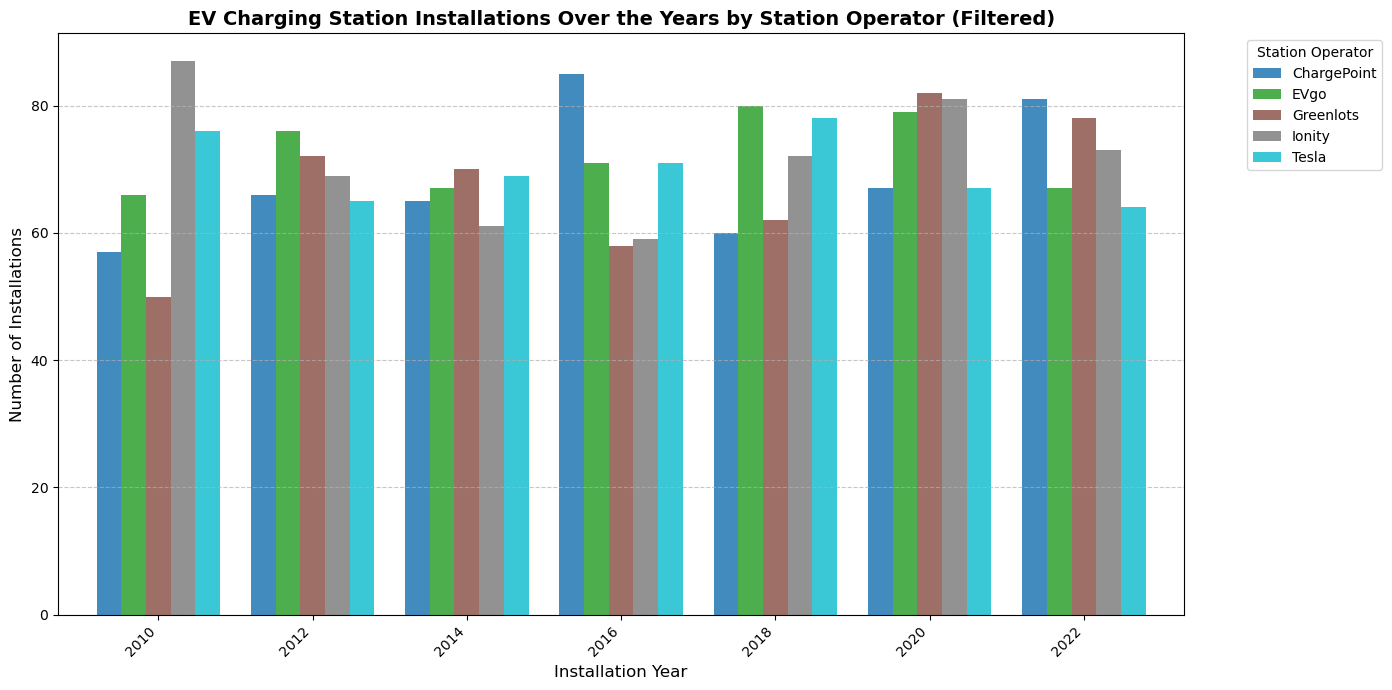

In [ ]:
# 2.  Part 1: Trend in EV Installations Over the Years
# ----------------------------------------------------------------------------------------------------------------------------------

# Aggregate Installation Counts Per Year and Station Operator
installations_per_operator = detailed_ev_charging_station.groupby(['Installation Year', 'Station Operator']).size().unstack(fill_value=0)

# Filter to Keep Every Other Year
filtered_years = installations_per_operator.index[::2]  # Selects every other year
installations_per_operator = installations_per_operator.loc[filtered_years]

# Plot Grouped Bar Chart
plt.figure(figsize=(14, 7))
installations_per_operator.plot(kind='bar', colormap='tab10', alpha=0.85, width=0.8, figsize=(14, 7))

# Labels and Titles
plt.title('EV Charging Station Installations Over the Years by Station Operator', fontsize=14, fontweight='bold')
plt.xlabel('Installation Year', fontsize=12)
plt.ylabel('Number of Installations', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a horizontal grid for clarity

# Legend & Layout Adjustments
plt.legend(title='Station Operator', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

# Show the Chart
plt.show()




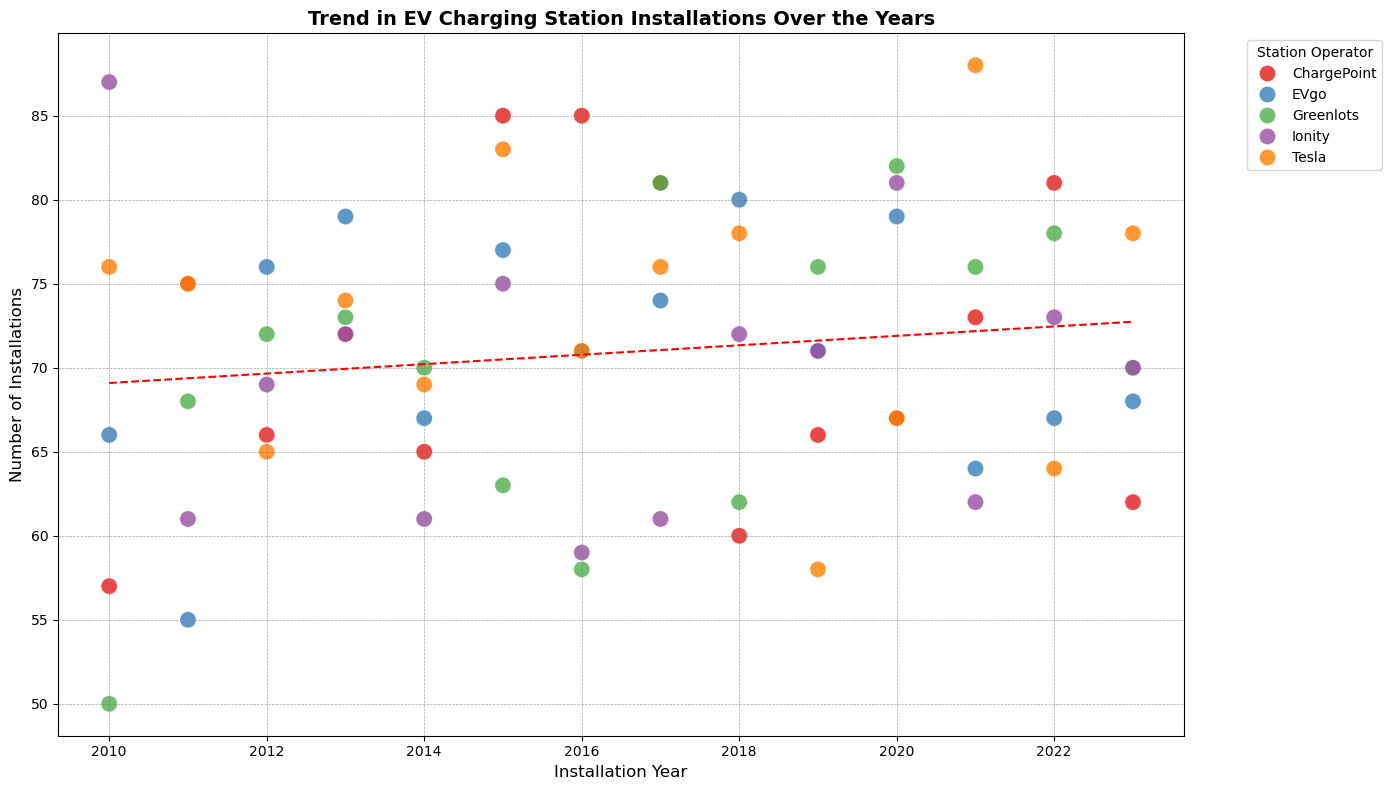

Pearson Correlation Coefficient: 0.14
R-squared Value: 0.02
P-value: 0.2517
count    70.000000
mean     70.914286
std       8.201702
min      50.000000
25%      65.250000
50%      71.000000
75%      76.000000
max      88.000000
Name: Installations, dtype: float64


In [85]:
# 2.  Part 2: Trend in EV Installations Over the Years
# ----------------------------------------------------------------------------------------------------------------------------------

# Create a New DataFrame with Relevant Columns
ev_installations = detailed_ev_charging_station[['Installation Year', 'Station Operator']].copy()

# Group Data by Installation Year and Station Operator
installations_per_year = ev_installations.groupby(['Installation Year', 'Station Operator']).size().reset_index(name='Installations')

# Regression Analysis
slope, intercept, r_value, p_value, std_err = linregress(installations_per_year['Installation Year'], installations_per_year['Installations'])

# Visualization: Scatter Plot with Regression Line
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='Installation Year', 
    y='Installations', 
    data=installations_per_year, 
    hue='Station Operator',            # Color based on Station Operator
    palette='Set1',                    # Color palette set
    s=150,                             # Marker size
    alpha=0.8,                         # Slight transparency
    legend='full'                      # Show full legend
)

# Add Regression Line
plt.plot(installations_per_year['Installation Year'], intercept + slope * installations_per_year['Installation Year'], color='red', linestyle='--')

# Plot Styling
plt.title('Trend in EV Charging Station Installations Over the Years', fontsize=14, fontweight='bold')
plt.xlabel('Installation Year', fontsize=12)
plt.ylabel('Number of Installations', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust Legend Placement
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Station Operator')

# Display the Plot
plt.tight_layout()
plt.show()

# Key Metrics Print Out
#----------------------
# Corelation Coefficient (Pearson's r) - measures the stength and direction of the linear relationship between two variables 
correlation = installations_per_year['Installation Year'].corr(installations_per_year['Installations'])
print(f"Pearson Correlation Coefficient: {correlation:.2f}")

# R - squared value 
print(f"R-squared Value: {r_value**2:.2f}")

# P- value
print(f"P-value: {p_value:.4f}")

# Shows summary of key data charectoristics like mean, median, variance, etc
print(installations_per_year['Installations'].describe())


# Calculate Year-over-Year (YoY) Growth Rate
installations_per_year['YoY Growth (%)'] = installations_per_year.groupby('Station Operator')['Installations'].pct_change() * 100

# Fix first-year growth rates by replacing NaN values with 0%
installations_per_year['YoY Growth (%)'] = installations_per_year['YoY Growth (%)'].fillna(0)





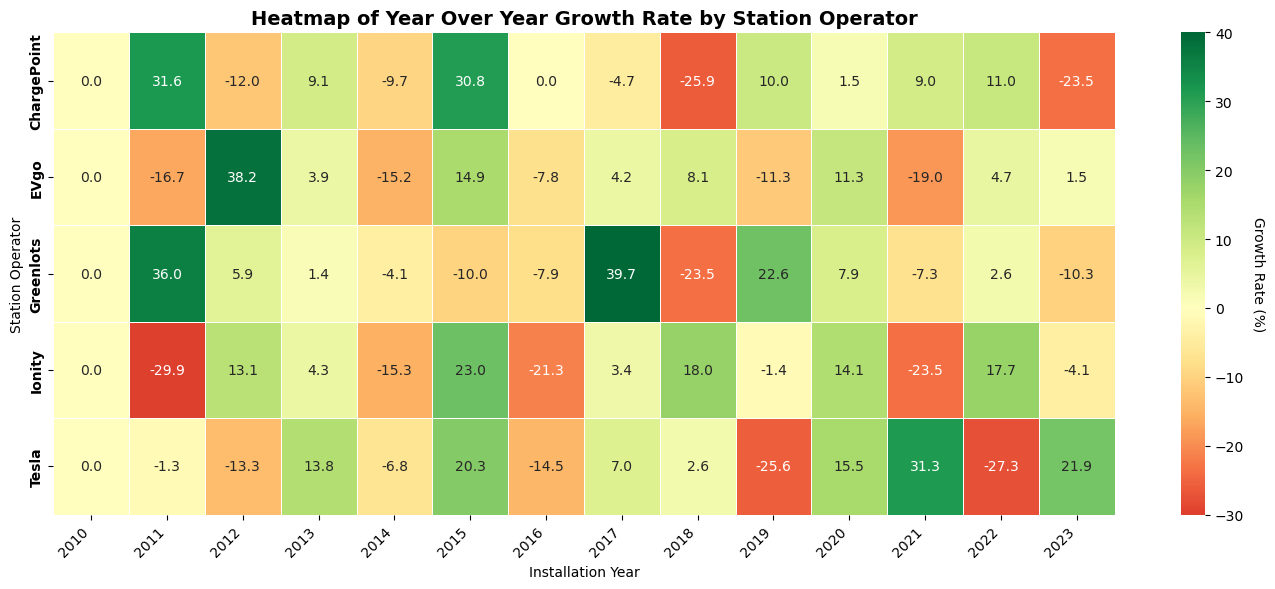

In [86]:
# 2.  Part 3: EV Instalations Year of Year Growth Rate
# ----------------------------------------------------------------------------------------------------------------------------------

# Data for Heatmap
installations_per_year['Installation Year'] = installations_per_year['Installation Year'].astype(int)
heatmap_data = installations_per_year.pivot(index='Station Operator', columns='Installation Year', values='YoY Growth (%)')

# Sort the years for proper display
heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)

# Fill missing values for consistent display
heatmap_data = heatmap_data.fillna(0)

# Heatmap Visualization
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(
    heatmap_data, 
    cmap='RdYlGn',                 # Green for positive growth, Red for negative
    annot=True,                      # Annotate cells with data
    fmt=".1f",                       # Format annotations
    linewidths=0.5,                  # Grid lines
    center=0,                        # Center around zero
    vmin=-30, vmax=40,               # Standardized color scaling
    annot_kws={"size": 10}          # Annotation size
)

# Plot Styling
plt.title('Heatmap of Year Over Year Growth Rate by Station Operator', fontsize=14, fontweight='bold')
plt.xlabel('Installation Year')
plt.ylabel('Station Operator')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels
plt.yticks(fontsize=10, fontweight='bold')        # Bold y-axis labels

# Add Color Bar Title
cbar = heatmap.collections[0].colorbar
cbar.set_label('Growth Rate (%)', rotation=270, labelpad=15)

plt.tight_layout()

# Display the Heatmap
plt.show()



/var/folders/3n/t0775bfj4931hr98hy7197340000gn/T/ipykernel_5060/36438835.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


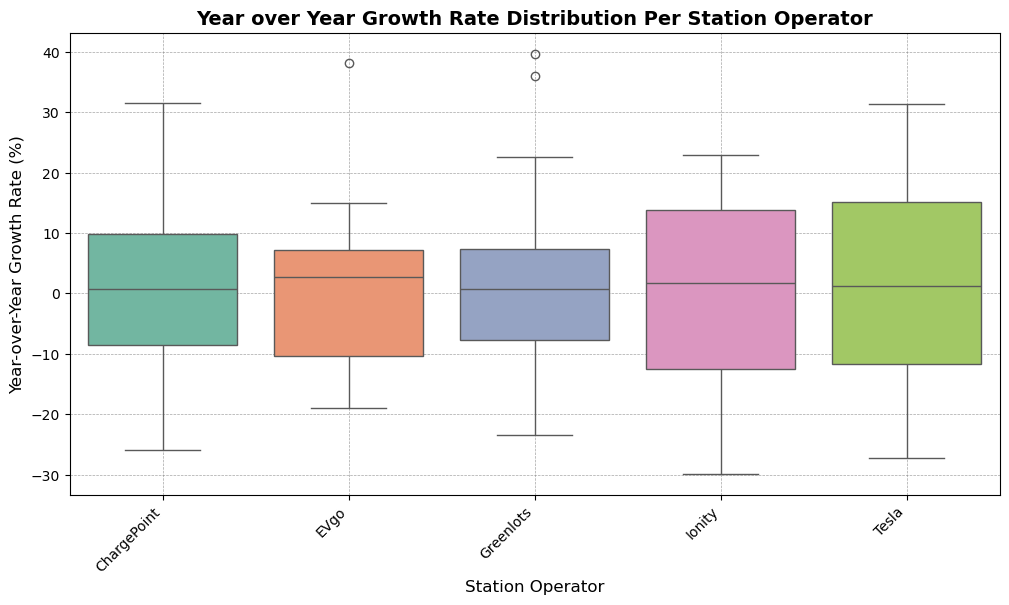

In [91]:
# 2.  Part 3: Box Plot: Growth Rate Year over Year Distribution Per Operator
# ----------------------------------------------------------------------------------------------------------------------------------

# Prepare Data for Box Plot
boxplot_data = installations_per_year[['Station Operator', 'YoY Growth (%)']].dropna()

# Create Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Station Operator', 
    y='YoY Growth (%)', 
    data=boxplot_data, 
    palette='Set2'  # Adjust the color scheme
)

# Plot Styling
plt.title('Year over Year Growth Rate Distribution Per Station Operator', fontsize=14, fontweight='bold')
plt.xlabel('Station Operator', fontsize=12)
plt.ylabel('Year-over-Year Growth Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Show Plot
plt.show()



In [ ]:
# 3.  Charging Capacity vs. Station Usage
# Correlation Analysis between "Charging Capacity (kw)" and "Usage Stats", Regression, and Visualize with Scatter Plot with Trend Line
# ------------------------------------------------------------------------------------------------------------------------------------

# New Instalations 

# Correlation Analysis 

# Incorporate geoapify mapping 

# Regression Analysis 

# Build 1-2 data visulatization Scatter Plot with Regression Line 

In [ ]:
# 4.  Impact of 24/7 Availability on Usage
# Data Filtering, Statistical Comparison, and Box Plot Visualization to compare distribution
# ------------------------------------------------------------------------------------------

# Filter Data 

# Compare Usage between 24/7 stations and limiited hour stations

# Calculate Average Daily Usage for both Categories 

# Build 1-2 data visualization using Box Plot and or Bar Charts 

In [ ]:
# 5.  City-Wise Usage Analysis
# Group Data by City, Analyze Usage Patterns, and Visualize with Geoapify (placeholder for API integration)
# ---------------------------------------------------------------------------------------------------------

# Group Data by City

# Calculate average daily usage 

# Identify cities with highest and lowest utilization rates 

# Geoapify integration for mapping stations, map charging stations 

# Build 1-2 Data Visualizations for city usage, geospatial maps 

In [ ]:
# 6.  Cost Analysis by City
# Calculate Average Cost per kWh, Visualize with Pie Chart
# ----------------------------------------------------------

#Group Data by City 

# Calculate the average cost and distribution of costs.  

# Geoapify integration for creating mapping usage 

# Pie Chart for cost distribution 

# Build 1-2 Data Visualizations for cost differences across regions 